In [1]:
import os
import process_observed_discharge as q
import glob
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

#segoe UI font
plt.rcParams['font.family'] = 'Segoe UI'


### Unzip files and copy to common folder
First unzip the files in individual folders and then transfer the tmeseries files into a common folder. For this, use the uzip_files and copy_to_common_folder  functions in the process_observed_discharge module

In [2]:
src_zipped_wallonie = 'D:/VUB/_data/hydrometrie_wallonie/rawfiles'
common_folder_wallonie = 'D:/VUB/_data/hydrometrie_wallonie/unzipped_all'

src_zipped_waterinfo = 'D:/VUB/_data/waterinfo/zipped'
common_folder_waterinfo = 'D:/VUB/_data/waterinfo/unzipped'

#For stations in Flanders, the station metadata is downloaded from the Waterinfo website using the py_waterinfo package.
#I decided to download the timeseries one by one because I struggled with the py_waterinfo package. It also helped me to skip data from canals
#The data has been processed using the download_waterinfo_data.ipynb notebook and saved as a csv file (waterinfo_Q_Stations.csv).
#The csv file contains the station name and coordinates.
#Since we do not need to use Q data from canals, we filter out the stations that are not rivers.

#### Unzip the files (both Wallonie and Waterinfo)

In [3]:
#q.unzip_files(src_zipped_waterinfo, common_folder_waterinfo)

#copy files to common folder
#q.copy_to_common_folder(src_zipped, common_folder)

#### Extract station timeseries and coordinates for Wallonie data

From the list of downloaded and unzipped files, process the files to obtain station names and coordinates and properly formatted timeseries

In [4]:
#This part of the code takes a while to run, so we wrap it inside pickle function
#Q_dict, station_coords = q.extract_timeseries_wallonie(common_folder_wallonie)
Q_dict, station_coords = q.load_or_extract_wallonie_data(
    'Q_dict_wallonie.pickle',
    'station_coords_wallonie.pickle',
    q.extract_timeseries_wallonie,
    common_folder_wallonie
)

Loading cached Wallonie discharge data...


#### Intersect waterinfo timeseries with station metadata
Since we do not need to use Q data from canals, we filter out the stations that are not rivers, so that we only have 'natural' flows

In [5]:
src_waterinfo = 'D:/VUB/_data/waterinfo/unzipped'
waterinfo_timeseries = glob.glob(os.path.join(src_waterinfo, '*.csv'))
waterinfo_station_metadata = pd.read_csv('waterinfo_Q_Stations.csv')

waterinfo_natural_stations = []
waterinfo_natural_Q = {}

for file in waterinfo_timeseries:
    df  = pd.read_csv(file, sep=';', header=None, skiprows=8)
    #select only the columns we need
    df = df.iloc[:, [0, 1]]
    df.columns = ['Date', 'Q']

    #Date to datetime 2005-07-18T01:00:00.000+02:00
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S.%f%z')

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Date'] = df['Date'].dt.tz_localize(None).dt.normalize()

    #set date as index
    df.set_index('Date', inplace=True)


    #replace ',' with '.' in Q column ans convert to float
    df['Q'] = df['Q'].str.replace(',', '.').astype(float)

    #extract the station name from the file name and remove the _Discharge part
    raw_name = os.path.basename(file).split('.')[0]
    station_name = re.sub(r'_Discharge$|_+$', '', raw_name) # Remove any trailing underscores

    waterinfo_natural_stations.append(station_name)
    waterinfo_natural_Q[station_name] = df


#filter the waterinfo_station_metadata dataframe to only include the stations that are in the waterinfo_natural_stations list
waterinfo_natural_metadata = waterinfo_station_metadata[waterinfo_station_metadata['station_name'].isin(waterinfo_natural_stations)]

In [6]:
missing = set(waterinfo_natural_stations) - set(waterinfo_station_metadata['station_name'])
len(missing)

#This means there are some stations which have data but their coordinates are not in the metadata file.
#We will only use the stations that are in the metadata file, whose coordinates are known.

17

#### Join Waterinfo and Wallonie station metadata
This will be used to extract the simulated flow from mHM.

To reduce runtime, we will only medium-sized stations with minimum peak flows of say 20m ${^3}/s$ and at least ten years of data

In [7]:
def extract_eval_stations(Q_dict, threshold_max, min_length_days):
    """
    Extracts stations for model evaluation based on peak discharge and non-NaN data length.
    
    Parameters:
    Q_dict (dict): Dictionary of station names → time series DataFrames with a 'Q' column.
    threshold_max (float): Minimum peak discharge (Q) required for inclusion.
    min_length_days (int): Minimum number of valid (non-NaN) daily discharge values required.
    
    Returns:
    eval_stations (dict): Dictionary of stations that meet the criteria.
    """
    eval_stations = {}

    for station_name, df in Q_dict.items():
        if 'Q' not in df.columns:
            continue  # Skip if 'Q' column is missing

        q_valid = df['Q'].dropna()
        max_Q = q_valid.max()
        valid_days = len(q_valid)

        if max_Q > threshold_max and valid_days >= min_length_days:
            eval_stations[station_name] = df
        # Optionally log excluded stations:
        # else:
        #     print(f"Excluded {station_name}: max Q = {max_Q}, valid days = {valid_days}")

    return eval_stations


In [8]:
threshold_max = 20 #this is the maximum Q in the timeseries, can be adjusted
min_length_days = 1825 #this is the minimum number of days with valid data, can be adjusted

#Get the dictionary of evaluation timeseries df
eval_stations_wallonie = q.extract_eval_stations(Q_dict, threshold_max, min_length_days)
eval_stations_waterinfo = q.extract_eval_stations(waterinfo_natural_Q, threshold_max, min_length_days)

In [9]:
len(list(eval_stations_waterinfo.keys()))

51

In [10]:
#Extract the coordinates of the evaluation stations from the station_coords dataframe
eval_stations_wallonie_coords = station_coords[station_coords['station_name'].isin(eval_stations_wallonie)]
eval_stations_waterinfo_coords = waterinfo_natural_metadata[waterinfo_natural_metadata['station_name'].isin(eval_stations_waterinfo)]

#concateneate station metadata for evaluation stations for wallonie and waterinfo
all_eval_stations = pd.concat([eval_stations_wallonie_coords, eval_stations_waterinfo_coords], axis=0)
all_eval_stations.columns = ['name', 'lat', 'lon']

#These are the stations that will be used to extract simulated data from the model and use used to evaluate the model performance
all_eval_stations.to_csv('mHM_eval_stations.csv', index=False) 

In [11]:
#Combine the Q dictionaries for waterinfo and wallonie
all_eval_stations_Q = {**eval_stations_wallonie, **eval_stations_waterinfo}

#From this extract dfs for the evaluation stations based on all evaluation stations
eval_stations_Q = {}
for station in all_eval_stations['name']:
    if station in all_eval_stations_Q:
        eval_stations_Q[station] = all_eval_stations_Q[station]
    else:
        print(f"Station {station} not found in the Q dictionary")


#### Extract Simulated Q from mHM

(Only Run Once)

In [12]:
#now to perform performance evaluation of the model, the simulated data is extracted using the hpc to save time
#alternatively,do it here
dataset_path = 'W:/VUB/_main_research/mHM/mhm_outputs/mHM_EOBS/mRM_Fluxes_States.nc'
station_files = 'mHM_eval_stations.csv'
var = 'Qrouted'

#extract the simulated data for the evaluation stations
#q.extract_netCDF_timeseries(dataset_path, station_files, var)

#### Remove stations on artificial canals

Since their flow is not natural, they cannot be used for model evaluation
I discovered the stations by visual inspection of the timeseries signal and the locations on the map

In [13]:
canals = ['HACCOURT']

#remove the canals from the eval stations DICTIONARY
for canal in canals:
    if canal in eval_stations_Q:
        del eval_stations_Q[canal]
        print(f"Removed {canal} from the evaluation stations dictionary")
    else:
        print(f"{canal} not found in the evaluation stations dictionary")

Removed HACCOURT from the evaluation stations dictionary


#### Model Performance Evaluation

In [14]:
sim_df_files = glob.glob(os.path.join('extracted_timeseries/Qrouted', '*.csv'))

model_metrics_cal = {}
model_metrics_val = {}

for file in sim_df_files:
    raw_name = os.path.basename(file).split('.')[0]
    station = raw_name  # Fix undefined variable

    df_sim = pd.read_csv(file, parse_dates=['time'], index_col='time')

    #select observed data for the station and skip if the station is not in the all_eval_stations_Q dictionary
    if station not in eval_stations_Q:
        print(f"Station {station} not found in all_eval_stations_Q")
        continue
    df_obs = eval_stations_Q[station].copy()

    df_obs.replace(-9999, np.nan, inplace=True)
    df_obs = df_obs.resample('D').mean()

    obs_sim = pd.concat([df_obs, df_sim], axis=1)
    obs_sim.columns = ['observed', 'simulated']
    obs_sim.dropna(inplace=True)

    #Calibration period: 2010 onward
    cal = obs_sim[obs_sim.index >= pd.to_datetime('2010-01-01')]

    #cal should be at least 3 years long
    if len(cal) < 3 * 365:
        msg = f"Validation period for {station} is too short: {len(cal)} days"
        print(msg.ljust(80), end='\r')
        continue
    
    # Validation period: before 2010
    val = obs_sim[obs_sim.index < pd.to_datetime('2010-01-01')]
    
    #val should be at least 3 years long
    if len(val) < 3 * 365:
        msg = f"Validation period for {station} is too short: {len(val)} days"
        print(msg.ljust(80), end='\r')
        continue

    # Calculate metrics only if data exists
    if not cal.empty:
        model_metrics_cal[station] = q.compute_model_metrics(cal['observed'], cal['simulated'])
        model_metrics_cal[station] = q.compute_model_metrics(cal['observed'], cal['simulated'])
    else:
        model_metrics_cal[station] = None
        model_metrics_cal[station] = None

    if not val.empty:
        model_metrics_val[station] = q.compute_model_metrics(val['observed'], val['simulated'])
        model_metrics_val[station] = q.compute_model_metrics(val['observed'], val['simulated'])
    else:
        model_metrics_val[station] = None
        model_metrics_val[station] = None

Station HACCOURT not found in all_eval_stations_Qt: 0 days                      


In [15]:
# Make sure you're working with NumPy arrays of float type
observed = np.array(cal['observed'], dtype=float)
simulated = np.array(cal['simulated'], dtype=float)

# Drop any NaNs (or infinite values if needed)
mask = ~np.isnan(observed) & ~np.isnan(simulated)
observed = observed[mask]
simulated = simulated[mask]

# Now apply log safely
epsilon = 1e-10
log_obs = np.log(observed + epsilon)
log_sim = np.log(simulated + epsilon)


#### Plot model vs observed timeseries for any station

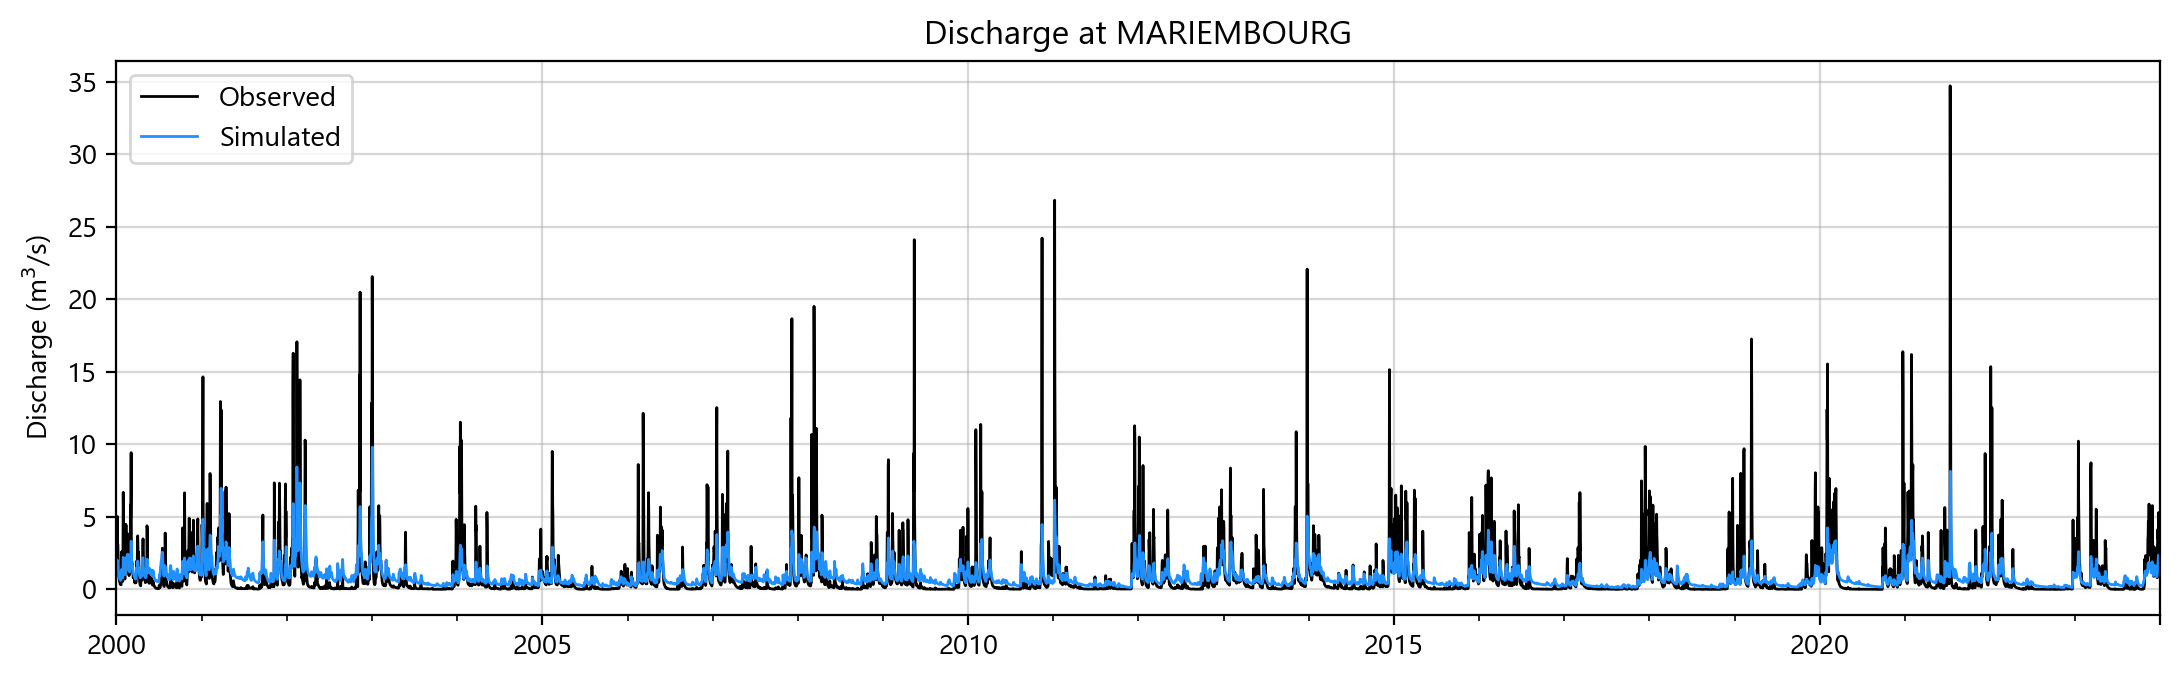

In [21]:
station = 'MARIEMBOURG'
observed_data_dict = all_eval_stations_Q
simulated_Q_dir = 'extracted_timeseries/Qrouted'

q.plot_station_timeseries(station,
                          observed_data_dict,
                          simulated_Q_dir)


In [17]:
#select the keys as columns
cols = list(model_metrics_cal[station].keys())

nse_values_cal_df = pd.DataFrame.from_dict(model_metrics_val, orient='index', columns=cols)

In [22]:
#nse_values_cal_df['KGE'].nlargest(90)

#### Map the NSE, LNSE and KGE values

In [ ]:
#For each station, get the performance metrics and join them to the station metadata so that we can map them
import geopandas as gpd
import matplotlib.pyplot as plt

# Merge NSE values with metadata
meta = all_eval_stations.copy()  # Your station metadata with lat/lon
meta['NSE_cal'] = meta['name'].map(nse_values_cal_df)

gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.lon, meta.lat), crs='EPSG:4326')

# Plot
gdf.plot(column='NSE_cal', cmap='viridis', legend=True, figsize=(8, 8))
plt.title('Calibration NSE per station')
plt.show()


In [28]:
meta

,name,lat,lon
0,Couvin,50.033584,4.495660
4,COMBLAIN-AU-PONT,50.485882,5.582982
5,COUVIN,50.040907,4.499700
7,Lommersweiler,50.234494,6.153955
8,Lorcé,50.409536,5.769068
...,...,...,...
159,Molenstede_Demer,50.991267,5.041367
166,Geel_Grote Nete,51.144787,5.003910
180,Moelingen_Berwijn,50.756746,5.713314
190,Herentals_KleineNete_Nederrij,51.185493,4.837851
